In [1]:
!pip install matplotlib python-sat    

     |████████████████████████████████| 1.8MB 14.1MB/s 


In [2]:
import os
import numpy as np
from pysat.solvers import Glucose3
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from fractions import Fraction

In [3]:
class Pos:
  def __init__(self, *arr):
    assert len(arr) == 2
    self.xy = arr

  def __add__(self, that):
    return [a + b for a, b in zip(self.xy, that.xy)]
  
  def __sub__(self, that):
    return [a - b for a, b in zip(self.xy, that.xy)]
  
  def __neg__(self):
    return [-a for a in self.xy]
  
  def __str__(self):
    return str(self.xy)
  
  def __repr__(self):
    return str(self)
  
  def __getitem__(self, index):
    return self.xy[index]

  def npArray(self):
    return np.array(self.xy)
  
  def parse(s):
    arr = [int(a) for a in s.split(',')]
    return Pos(*arr)


class Box:
  def __init__(self, line):
    arr = line.split('\t')
    self.pos = Pos.parse(arr[0])
    self.size = Pos.parse(arr[1])
    self.offsets = [Pos.parse(pos) for pos in arr[2].split(' ')]
    assert len(self.offsets) > 0
  
  def __str__(self):
    return 'Box(pos={}, size={}, offsets={})'.format(self.pos, self.size, self.offsets)
  
  def __repr__(self):
    return str(self)

In [4]:
def getShiftNumber(size, offset, possibleShifts):
  shift = Fraction(offset[0], size[0]), Fraction(offset[1], size[1])
  if shift not in possibleShifts:
    possibleShifts[shift] = len(possibleShifts)
  return possibleShifts[shift]

def generateBoxWithShifts(box, possibleShifts):
  #переводит боксы со смещениями в смещенные боксы с номером смещения 
  boxes = []
  for offset in box.offsets:
    #нумерует смещение, чтобы можно было сопоставить перменные
    shift = Fraction(offset[0], box.size[0]), Fraction(offset[1], box.size[1])
    if shift not in possibleShifts:
      possibleShifts[shift] = len(possibleShifts)
    shiftNumber = possibleShifts[shift]
    shiftedBox = np.zeros(4)
    shiftedBox[:2] = (box.pos.npArray() - offset.npArray())
    shiftedBox[2:] = (box.pos.npArray() - offset.npArray() + box.size.npArray())
    boxes.append((shiftedBox, shiftNumber))
  return boxes

def intercect(box1, box2):
  dx = min(box1[2], box2[2]) - max(box1[0], box2[0])
  dy = min(box1[3], box2[3]) - max(box1[1], box2[1])
  return (dx>=0) and (dy>=0) 

In [5]:
def chooseBoxesShifts(boxesWithShifts, shiftsCount):
  #строим задачу и находим решение
  g = Glucose3()

  for i in range(len(boxesWithShifts)):
    #не больше одного из всех вариантов расположения
    for k in range(len(boxesWithShifts[i])):
      for j in range(k+1, len(boxesWithShifts[i])):
        g.add_clause([-((i+1)*shiftsCount + boxesWithShifts[i][k][1]), -((i+1)*shiftsCount + boxesWithShifts[i][j][1])])
    
    #хотя бы 1 расположение
    g.add_clause([(i+1)*shiftsCount + boxesWithShifts[i][j][1] for j in range(len(boxesWithShifts[i]))])
  
    for box, shiftNumber in boxesWithShifts[i]:
      if box[0] < 0 or box[1] < 0 or box[2] > 500 or box[3] > 500: #меньше 500*500
        g.add_clause([-((i+1)*shiftsCount + shiftNumber)])

    for j in range(i+1, len(boxesWithShifts)):
      for box1, shift1Number in boxesWithShifts[i]:
        for box2, shift2Number in boxesWithShifts[j]:
          if intercect(box1, box2):
            g.add_clause([-((i+1)*shiftsCount + shift1Number), -((j+1)*shiftsCount + shift2Number)])
  
  if not g.solve():
    return None

  return g.get_model()

In [6]:
def draw(boxesWithShifts, solution, points, shiftsCount):
  #отрисовываем те боксы со смещениями, которые были выбраны
  fig, ax = plt.subplots(figsize=(12,8))
  scatter_x = [point.pos[0] for point in points]
  scatter_y = [point.pos[1] for point in points]
  ax.scatter(scatter_x, scatter_y, color='green')
  for i in solution:
    if i > 0:
      boxIndex = i//shiftsCount - 1
      shiftIndex = i % shiftsCount
      for box, shiftNumber in boxesWithShifts[boxIndex]:
        if shiftNumber == shiftIndex:
          rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, alpha=0.3)
          ax.add_patch(rect)
  plt.show()

def validate(shiftsToUse, boxesWithShifts):
  assert shiftsToUse is not None, "Невозможно отрисовать"
  #проверяем, что количество совпало
  assert np.sum(np.array(shiftsToUse) > 0) == len(boxesWithShifts) 

def createShiftedBoxes(boxes, possibleShifts):
  boxesWithShifts = [generateBoxWithShifts(box, possibleShifts) for box in boxes]
  shiftsToUse = chooseBoxesShifts(boxesWithShifts, len(possibleShifts))
  return boxesWithShifts, shiftsToUse

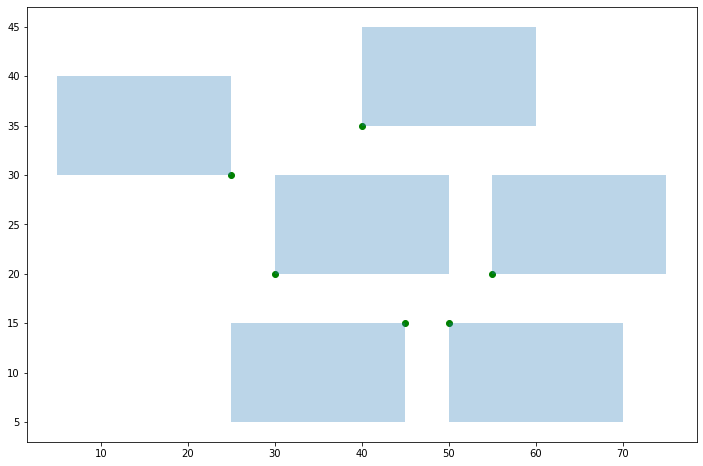

In [7]:
with open("test1.txt") as f:
  boxes = [Box(line) for line in f.read().strip().split('\n')]
possibleShifts = dict()
boxesWithShifts, shiftsToUse = createShiftedBoxes(boxes, possibleShifts)
validate(shiftsToUse, boxesWithShifts)
draw(boxesWithShifts, shiftsToUse, boxes, len(possibleShifts))

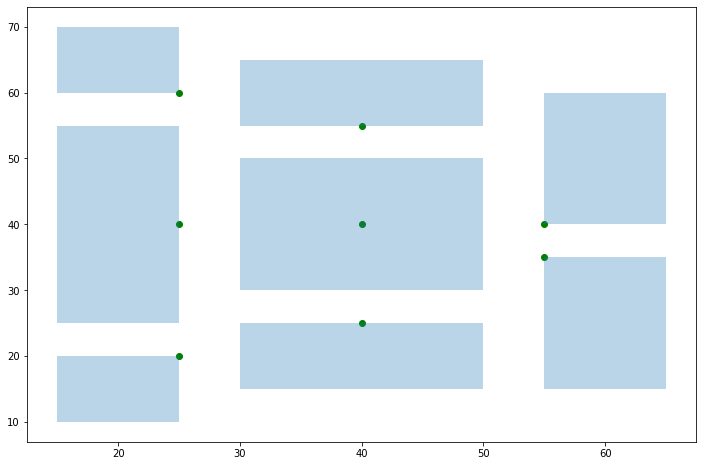

In [8]:
#@title Текст заголовка по умолчанию
with open("test2.txt") as f:
  boxes = [Box(line) for line in f.read().strip().split('\n')]
possibleShifts = dict()
boxesWithShifts, shiftsToUse = createShiftedBoxes(boxes, possibleShifts)
validate(shiftsToUse, boxesWithShifts)
draw(boxesWithShifts, shiftsToUse, boxes, len(possibleShifts))

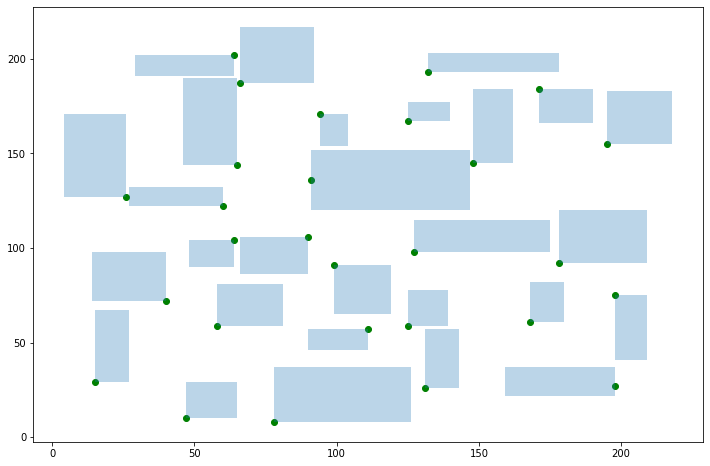

In [9]:
with open("test3.txt") as f:
  boxes = [Box(line) for line in f.read().strip().split('\n')]
possibleShifts = dict()
boxesWithShifts, shiftsToUse = createShiftedBoxes(boxes, possibleShifts)
validate(shiftsToUse, boxesWithShifts)
draw(boxesWithShifts, shiftsToUse, boxes, len(possibleShifts))